In [1]:
import warnings
import pickle
import pyaudio
import wave
import time
import matplotlib.pyplot       as plt
import numpy                   as np
import pandas                  as pd
from   itertools               import chain
from   tqdm.notebook           import tqdm, trange

import librosa
import librosa.display

import scipy.io.wavfile        as wavfile
from   scipy.fftpack           import fft
from   scipy                   import signal
from   scipy.stats             import binned_statistic
from   scipy.signal            import savgol_filter

from   sklearn.linear_model    import LogisticRegression
from   sklearn.cluster         import KMeans
from   sklearn.metrics         import classification_report, accuracy_score, confusion_matrix
from   sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
# load the model from disk
filename = 'bin_1_window'

with open('saved_models/' + filename + '_model.pkl', "rb") as f:
    loaded_model = pickle.load(f)

with open('saved_models/' + filename + '_clf_model.pkl', "rb") as f:
    loaded_clf_model = pickle.load(f)

In [3]:
class File:
    def __init__(self, file_type, num_files, samples, sampling_rate, fs, y, df):
        self.file_type               = file_type
        self.num_files               = num_files
        self.samples                 = samples
        self.sampling_rate           = sampling_rate
        self.fs                      = fs
        self.y                       = y
        self.num_bins                = 1024
        self.FFT_SIZE                = 1024
        self.window_size             = 0.25
        self.window_overlap          = 0.5
        self.xf                      = []
        self.yf                      = []
        self.bins                    = []
        self.bin_windows             = []
        self.domain_spec_f           = []
        self.domain_spec_f_windows   = []
        
        self.print_file(0)
        
    # calculate the fft for a specific wav file
    def fft_method(self, num, begin=0, end=None):
        if end == None:
            end=len(self.samples[num])
        
        # variables
        T = 1/self.sampling_rate
        N = len(self.samples[num][begin:end])
        
        # max frequency spectrum of the FFT.
        max_val = 1.0/(2.0*T) 
        num_vals = N//2  

        # calculate fft
        yf_all = fft(self.samples[num][begin:end])
        xf = np.linspace(0.0, max_val, num_vals)
        yf = 2.0/N * np.abs(yf_all[0:num_vals])

        return xf, yf
    
    # create a list of fft features for this class
    def create_fft(self):
        self.xf = []
        self.yf = []

        for one in range(self.num_files):
            self.xf.append(self.fft_method(one)[0])
            self.yf.append(self.fft_method(one)[1])
        
        #print the first wav file's fft
        self.graph_fft(0)
        
    # calculates the avg magnitude between two frequencies
    def calc_avg(self, xf, yf, length, min_freq, max_freq):
        l = []
        min_idx = -1
        max_idx = -1
        y_filtered = savgol_filter(yf, length, 3)
        for i in range(len(xf)):
            if xf[i] > min_freq and min_idx == -1:
                min_idx = i
            elif xf[i] > max_freq and max_idx == -1:
                max_idx = i - 1
            elif min_idx != -1 and max_idx != -1:
                break
        avg_l = y_filtered[min_idx:max_idx]
        
        if len(avg_l) == 0:
            avg = 0
        else:
            avg = sum(avg_l)/len(avg_l)
        return avg
    
    # create a list of domain-specifc features for this class
    def create_domain_spec_f(self, freqs):
        self.domain_spec_f = []

        for file in range(self.num_files):
            avg_l = []
            for one in freqs:
                avg_l.append(self.calc_avg(self.xf[file], self.yf[file], 99, one[0], one[1]))
            
            self.domain_spec_f.append(avg_l)
                        
    # create a list of domain-specifc features for this class
    def create_windowed_domain_spec_f(self, freqs):
        self.domain_spec_f_windows = []
        window_size      = int(len(self.samples[0]) * self.window_size)
        move_window      = int(len(self.samples[0]) * (self.window_size * self.window_overlap))
        
        for file in range(self.num_files):
            begin = 0
            end   = window_size
            
            for one in range(int(len(self.samples[0]) / self.window_overlap)):
                if begin >= len(self.samples[0]):
                    break
                    
                if end >= len(self.samples[0]):
                    end = len(self.samples[0])-1
 
                xf, yf = self.fft_method(file, begin, end)
    
                avg_l = []
                for one in freqs:
                    avg_l.append(self.calc_avg(xf, yf, 99 , one[0], one[1]))

                self.domain_spec_f_windows.append(avg_l)
                
                begin += move_window
                end   += move_window

    # calculate the bins for a specific file
    def bin_method(self, num):
        bins_of_file = [int(x) for x in binned_statistic(self.yf[num], 
                                                         self.yf[num], 
                                                         statistic='count', 
                                                         bins=self.num_bins)[0]]
        return bins_of_file
    
    # create a list of the bin features for this class    
    def create_bins_from_fft(self):
        self.bins = []

        for file in range(self.num_files):
            self.bins.append(self.bin_method(file))
            
        #print the bins of the first wav file in this class
        self.graph_bins(0)
        
    # create a list of windows with bin features for this class
    def create_windowed_bins_from_fft(self):
        self.bin_windows = []
        window_size      = int(len(self.samples[0]) * self.window_size)
        move_window      = int(len(self.samples[0]) * (self.window_size * self.window_overlap))
    
        for file in range(self.num_files):
            begin = 0
            end   = window_size
            
            for one in range(int(len(self.samples[0]) / self.window_overlap)):
                if begin >= len(self.samples[0]):
                    break
                    
                if end >= len(self.samples[0]):
                    end = len(self.samples[0])-1
 
                xf, yf = self.fft_method(file, begin, end)
                bin_window = [int(x) for x in binned_statistic(yf, 
                                                               yf, 
                                                               statistic='count', 
                                                               bins=self.num_bins)[0]]
                self.bin_windows.append(bin_window)
                begin += move_window
                end   += move_window
        
        self.graph_windowed_bins(0)
                    
    # graph the specified wav file of this class as a spectrogram
    def graph_spectrogram(self, num): 
        warnings.filterwarnings('ignore')
        f,t,pxx = signal.spectrogram(self.y[num], 
                                     nperseg=self.FFT_SIZE, 
                                     fs=self.fs[num], 
                                     noverlap=self.FFT_SIZE/2)
        %matplotlib inline
        cmap=plt.cm.bone
        cmap.set_under(color='k', alpha=None)
        plt.title("Spectrogram")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Frequency (Hz)")
        plt.pcolormesh(np.log10(pxx[:,:]),cmap=cmap)
        
    # graph the specified file of this class as a fft
    def graph_fft(self, num):
        if PRINT_GRAPH:
            plt.figure()
            plt.title("Fast Fourier Transform")
            plt.plot(self.xf[num], self.yf[num])
            plt.grid()
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.show()

    # graph the specified file of this class as a wave form        
    def graph_wave_form(self, num):
        if PRINT_GRAPH:
            plt.figure()
            plt.title("Wave Form")
            librosa.display.waveshow(self.samples[num], sr=self.sampling_rate)
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude")
            plt.show()
     
    # graph the specified file of this class as a bins
    def graph_bins(self, num):
        if PRINT_GRAPH:
            plt.figure()
            plt.title("Bins")
            plt.xlabel("Bin Index")
            plt.ylabel("Count")
            plt.bar(range(0, self.num_bins), self.bins[num])
            plt.show()
        
    # graph the specified file of this class as a windowed bins
    def graph_windowed_bins(self, num):
        if PRINT_GRAPH:
            plt.figure()
            plt.title("Bins")
            plt.xlabel("Bin Index")
            plt.ylabel("Count")
            plt.bar(range(0, len(self.bin_windows[num])), self.bin_windows[num])
            plt.show()
    
    # graph the specified file of this class
    def print_file(self, num):
        if PRINT_GRAPH:
            print("-----------------")
            print(f"File Type:     {self.file_type}")
            print(f"Num Files:     {self.num_files}")
            print(f"Samples:       {len(self.samples[0])}")
            print(f"Sampling rate: {self.sampling_rate}")
            print("-----------------")

            self.graph_wave_form(num)
#             self.graph_spectrogram(num)
        
# load the class into data and print the first file
def load_file(file_type, path, if_song):
    num_files = 0
    fs        = []
    y         = []
    samples   = []   
    
    file_path = path
    tmp_samples, tmp_sampling_rate  = librosa.load(file_path, 
                                                   sr=None, 
                                                   mono=True, 
                                                   offset=0.0, 
                                                   duration=None)
    
    num_files     += 1
#     tmp_fs, tmp_y  = wavfile.read(file_path)
#     print(np.shape(tmp_fs))
#     print(np.shape(tmp_y))
#     fs.append(tmp_fs)
#     y.append(np.array([x[0] for x in tmp_y]))
    samples.append(tmp_samples)

    sampling_rate = tmp_sampling_rate

    if sampling_rate != tmp_sampling_rate:
        print("Error: sampling rate is inconsistent!")
        return

    df = pd.DataFrame()

    return File(file_type, num_files, samples, sampling_rate, fs, y, df)

In [4]:
# grab sound file and write to disc
def record(file_name):
    FORMAT               = pyaudio.paInt16
    CHANNELS             = 2
    RATE                 = 16000
    CHUNK                = 1024
    RECORD_SECONDS       = 32
    WAVE_OUTPUT_FILENAME = file_name

    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print("recording...")
    frames = []

    for i in trange(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

#     print("finished recording")
    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

#     print("write file")
    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

In [11]:
# KMEANS Prediction Vals
# 0 Blender
# 1 Microwave
# 2 Song
# 3 Vacuum
# 4 Fire Alarm

def predict(file_name):
    warnings.filterwarnings('ignore')
    print("Predict")

    # read in the new .wav file
    test_class = load_file("test", file_name, 0)
    
#     plt.figure()
#     plt.title("Wave Form")
#     librosa.display.waveshow(test_class.samples[0], sr=test_class.sampling_rate)
#     plt.xlabel("Time (seconds)")
#     plt.ylabel("Amplitude")
#     plt.show()

    # calculate fft
    test_class.create_fft()
    
    #clean the data of unecisary frequencies 
    last = 1925
    test_class.xf[0] = test_class.xf[0][last:]
    test_class.yf[0] = test_class.yf[0][last:]
    test_class.graph_fft(0)

    # calclate bins
    test_class.create_bins_from_fft()   

    # convert data
    bins = []
    bins.extend(test_class.bins)   
    X_test = pd.DataFrame(bins)

    # predict KMeans
    X_test['km_clust'] = loaded_clf_model.predict(X_test)

    # predict SVM
    result = loaded_model.predict(X_test)

    print(result)
    print(" ")

In [6]:
# file_name = "Recordings/Song/song_f_2.wav"
# predict(file_name)

# file_name = "Recordings/Fire_Alarm/fire_alarm_2.wav"
# predict(file_name)

# file_name = "Recordings/Vacuum/vacuum_2.wav"
# predict(file_name)

# file_name = "Recordings/Microwave/microwave_2.wav"
# predict(file_name)

# file_name = "Recordings/Blender/blender_2.wav"
# predict(file_name)

In [13]:
# PRINT_GRAPH = 0
# file_name   = "file.wav"

# while 1:
#     record(file_name)
#     predict(file_name)

recording...


  0%|          | 0/500 [00:00<?, ?it/s]

Predict
-----------------
File Type:     test
Num Files:     1
Samples:       512000
Sampling rate: 16000
-----------------


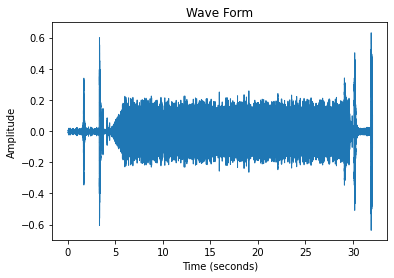

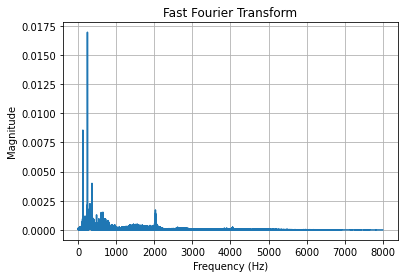

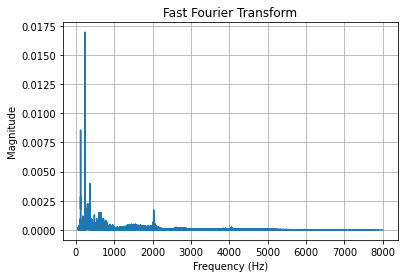

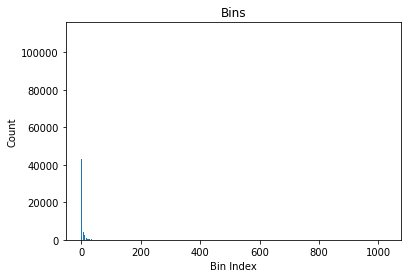

['fire_alarm']
 


In [16]:
PRINT_GRAPH = 1
file_name   = "file.wav"

record(file_name)
predict(file_name)